<a href="https://colab.research.google.com/github/opticalcode/Hachioji-AI-biginner/blob/master/Python%E3%81%AEstatsmodels%E3%81%A7%E6%99%82%E7%B3%BB%E5%88%97%E5%88%86%E6%9E%90%E3%82%92%E3%81%99%E3%82%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

使用するライブラリ

In [20]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import requests
import io
from matplotlib import pylab as plt
%matplotlib inline
# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

データ

In [21]:
URL = "https://drive.google.com/uc?id=1MZMKbSQXeVnlAWijTC_hwFCCxPbYNX-Y"

r = requests.get(URL)
row_data = pd.read_csv(io.BytesIO(r.content))

In [4]:
row_data.head()

,date,earnings,temperature
0,2014/1/1,396.0,3.9
1,2014/2/1,309.0,3.5
2,2014/3/1,447.0,7.4
3,2014/4/1,520.0,12.4
4,2014/5/1,803.0,18.0


In [5]:
# float型にしないとモデルを推定する際にエラーがでる
row_data.earnings = row_data.earnings.astype('float64')
row_data.temperature = row_data.temperature.astype('float64')
# datetime型にしてインデックスにする
row_data.date = pd.to_datetime(row_data.date)
data = row_data.set_index("date")

In [6]:
data.head()

,earnings,temperature
date,,
2014-01-01,396.0,3.9
2014-02-01,309.0,3.5
2014-03-01,447.0,7.4
2014-04-01,520.0,12.4
2014-05-01,803.0,18.0


データの全体像を確認

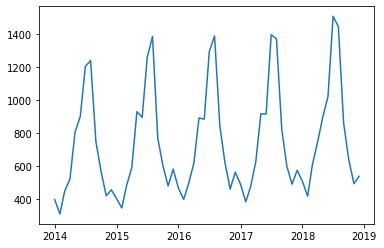

In [7]:
plt.plot(data.earnings)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


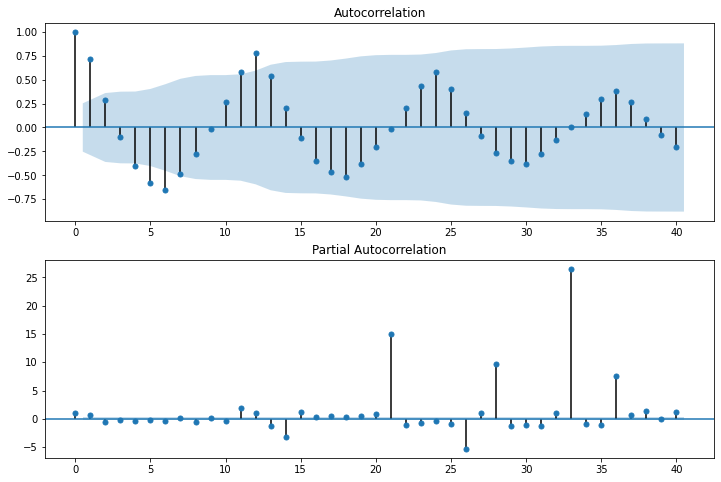

In [8]:
#  自己相関のグラフ
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.earnings, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.earnings, lags=40, ax=ax2)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

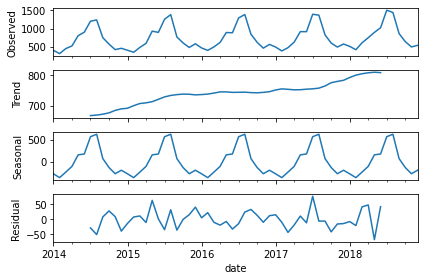

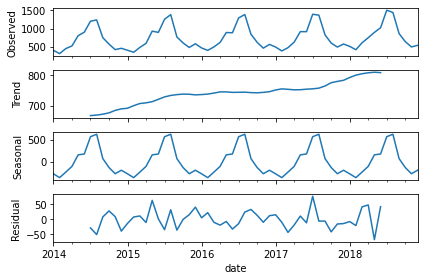

In [9]:
# データをトレンドと季節成分に分解
seasonal_decompose_res = sm.tsa.seasonal_decompose(data.earnings, freq=12)
seasonal_decompose_res.plot()

データを定常にしていく

In [10]:
# トレンド項あり（１次まで）、定数項あり
ct = sm.tsa.stattools.adfuller(data.earnings, regression="ct")
# トレンド項なし、定数項あり
c = sm.tsa.stattools.adfuller(data.earnings, regression="c")
# トレンド項なし、定数項なし
nc = sm.tsa.stattools.adfuller(data.earnings, regression="nc")

print("ct:")
print(ct[1])
print("---------------------------------------------------------------------------------------------------------------")
print("c:")
print(c[1])
print("---------------------------------------------------------------------------------------------------------------")
print("nc:")
print(nc[1])
print("---------------------------------------------------------------------------------------------------------------")

ct:
0.8817442987080415
---------------------------------------------------------------------------------------------------------------
c:
0.8192957538918948
---------------------------------------------------------------------------------------------------------------
nc:
0.9999999896927978
---------------------------------------------------------------------------------------------------------------


In [11]:
diff = data.earnings.diff()
diff = diff.dropna()

# トレンド項あり（１次まで）、定数項あり
ct = sm.tsa.stattools.adfuller(diff, regression="ct")
# トレンド項なし、定数項あり
c = sm.tsa.stattools.adfuller(diff, regression="c")
# トレンド項なし、定数項なし
nc = sm.tsa.stattools.adfuller(diff, regression="nc")

print("ct:")
print(ct[1])
print("---------------------------------------------------------------------------------------------------------------")
print("c:")
print(c[1])
print("---------------------------------------------------------------------------------------------------------------")
print("nc:")
print(nc[1])
print("---------------------------------------------------------------------------------------------------------------")

ct:
0.005220302847136132
---------------------------------------------------------------------------------------------------------------
c:
0.0006567788221081032
---------------------------------------------------------------------------------------------------------------
nc:
0.001934447028666962
---------------------------------------------------------------------------------------------------------------


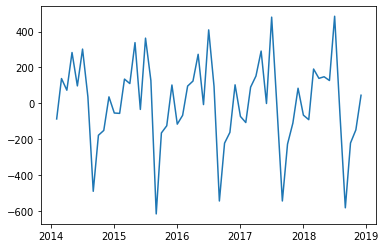

In [12]:
plt.plot(diff)

モデル推定

In [13]:
train_data = data[data.index < "2018-06"]
# テストデータはテスト期間以前の日付も含まなければいけない
test_data = data[data.index >= "2018-05"]

In [22]:
# 総当たりで、AICが最小となるSARIMAの次数を探す
max_p = 3
max_q = 3
max_d = 2
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_d + 1)*(max_q + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])

# 自動SARIMA選択
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            train_data.earnings, order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.iloc[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.iloc[num]["aic"] = sarima.aic
                        num = num + 1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python

In [23]:
modelSelection.sort_values(by='aic').head()

,model,aic
278,"order=(3,2,2), season=(1,1,0)",265.458
270,"order=(3,2,1), season=(1,1,0)",266.521
286,"order=(3,2,3), season=(1,1,0)",268.323
254,"order=(3,1,3), season=(1,1,0)",269.788
238,"order=(3,1,1), season=(1,1,0)",269.873


In [25]:
SARIMA_3_2_2_110 = sm.tsa.SARIMAX(train_data.earnings, order=(3,2,2), seasonal_order=(1,1,0,12)).fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [26]:
# Ljungbox検定
ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_3_2_2_110.resid, lags=10)
df_ljungbox_result = pd.DataFrame({"p-value":ljungbox_result[1]})
df_ljungbox_result[df_ljungbox_result["p-value"] <  0.05]

,p-value
0,0.001934
1,0.005046
2,0.005917
3,0.010949
4,0.018445
5,0.031618
6,0.018867
7,0.000824
8,0.000249
9,0.000466


In [27]:
#モデル推定
SARIMA_3_1_3_110 = sm.tsa.SARIMAX(train_data.earnings, order=(3,1,3), seasonal_order=(1,1,0,12)).fit()
# 残差の検定
ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_3_1_3_110.resid, lags=10)
# 結果
df_ljungbox_result = pd.DataFrame({"p-value":ljungbox_result[1]})
df_ljungbox_result[df_ljungbox_result["p-value"] <  0.05]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


,p-value


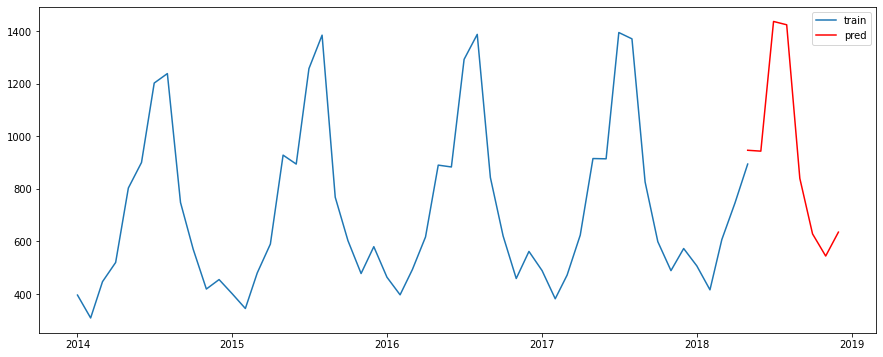

In [28]:
# 予測
pred = SARIMA_3_1_3_110.predict('2018-05-01', '2018-12-01')
# 実データと予測結果の図示
plt.plot(train_data.earnings, label="train")
plt.plot(pred, "r", label="pred")
plt.legend()

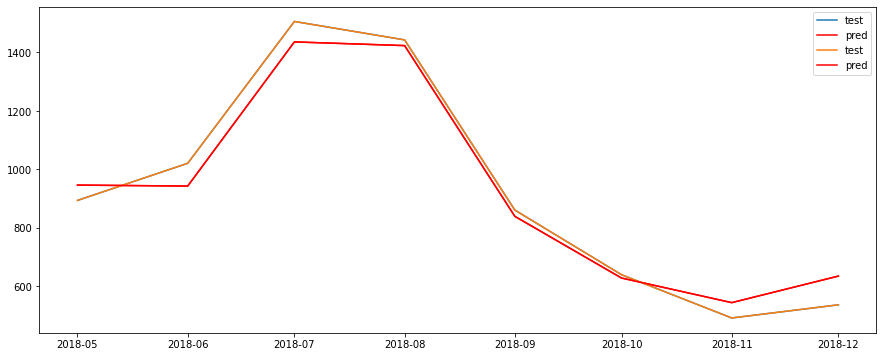

In [29]:
# 予測評価
pred = SARIMA_3_1_3_110.predict('2018-05-01', '2018-12-01')
# 実データと予測結果の図示
plt.plot(test_data.earnings, label="test")
plt.plot(pred, "r", label="pred")
plt.legend()# 予測評価
pred = SARIMA_3_1_3_110.predict('2018-05-01', '2018-12-01')
# 実データと予測結果の図示
plt.plot(test_data.earnings, label="test")
plt.plot(pred, "r", label="pred")
plt.legend()

In [30]:
SARIMA_3_1_3_110_with_exog = sm.tsa.SARIMAX(train_data.earnings, train_data.temperature, order=(3,1,3), seasonal_order=(1,1,0,12)).fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


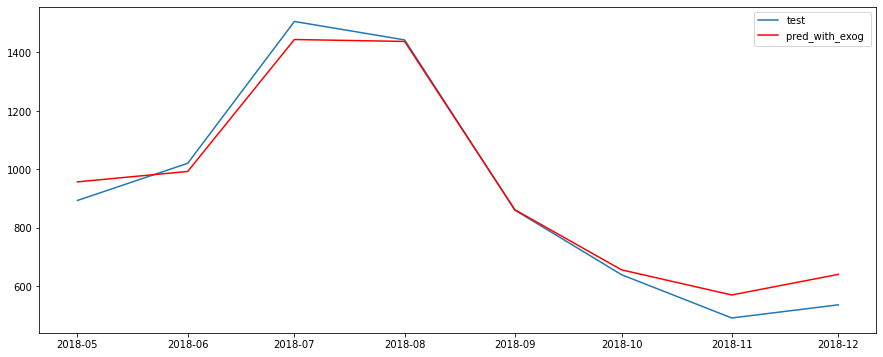

In [31]:
# 予測
# データを(7, 1)に変形する
test_temperature = [[test_data.temperature[i+1]] for i in range(7)]
pred_with_exog = SARIMA_3_1_3_110_with_exog.predict('2018-05-01', '2018-12-01', exog=test_temperature)
# 実データと予測結果の図示
plt.plot(test_data.earnings, label="test")
plt.plot(pred_with_exog , "r", label="pred_with_exog ")
plt.legend()